Isolation Forest model and scaler loaded successfully.
Loaded 6521 data points from dev101_resample10T.csv and dev102_resample10T.csv.

Missing values in 'label' column replaced with 'Normal'.
Anomaly scores calculated.

True Label Distribution:
true_label_mapped_multi
Normal      6473
Warning       31
Critical      17
Name: count, dtype: int64

--- Starting Threshold Optimization ---
Anomaly Score Range: -0.1392 to 0.2092
Testing 250 threshold candidates...
Progress: 0/250 critical thresholds tested...
Progress: 50/250 critical thresholds tested...
Progress: 100/250 critical thresholds tested...
Progress: 150/250 critical thresholds tested...
Progress: 200/250 critical thresholds tested...

Optimization completed!
Total combinations tested: 31125
Valid combinations: 31125

OPTIMAL THRESHOLDS FOR DIFFERENT OBJECTIVES

--- Weighted F1-Score Optimization ---
Best Weighted F1-Score: 0.9953
Critical Threshold: -0.0977
Warning Threshold: -0.0454
F1-Score per class: [0.75675676 0.54285714 0.

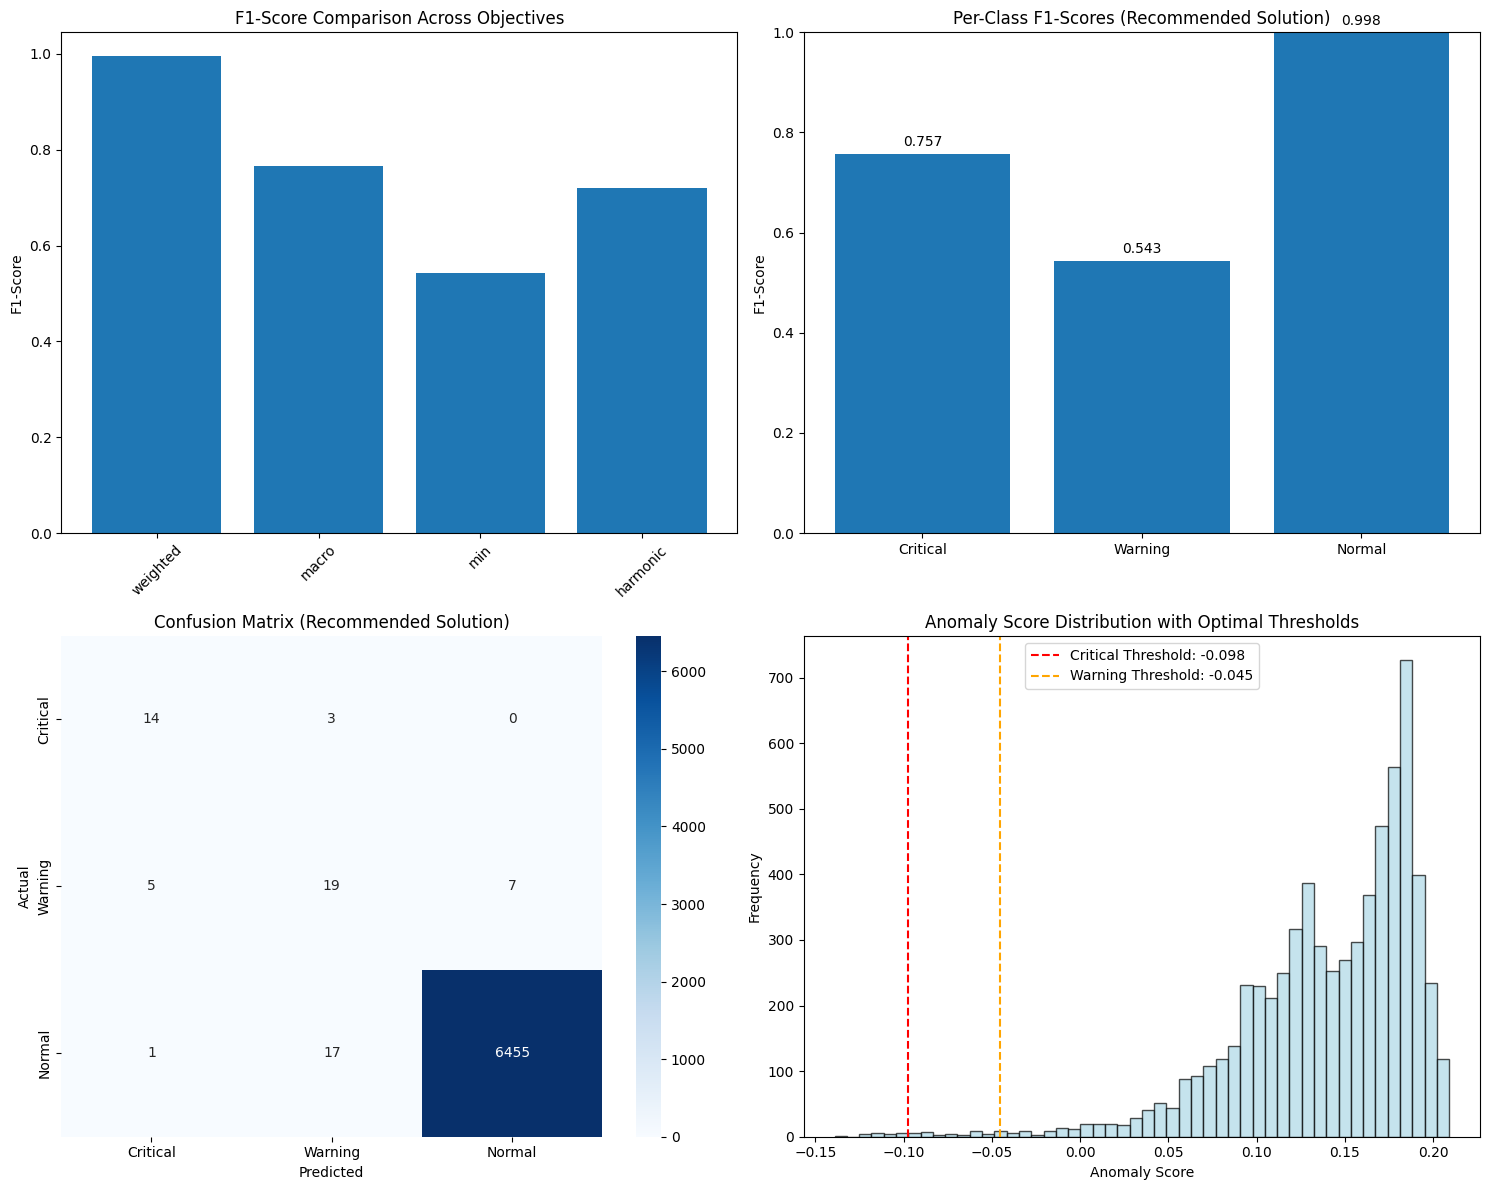


SUMMARY FOR IMPLEMENTATION

# Use these optimized thresholds in your code:
crit_thresh = -0.097692
warn_thresh = -0.045423

# Function to classify risk:
def classify_risk(score):
    if score < -0.097692:
        return "Critical"
    elif score < -0.045423:
        return "Warning"
    else:
        return "Normal"

# Performance achieved:
# - Weighted F1-Score: 0.9953
# - Macro F1-Score: 0.7659
# - Minimum F1-Score: 0.5429
# - F1-Score per class: [0.75675676 0.54285714 0.99806726]



In [1]:
import pandas as pd #d
import numpy as np
from joblib import load
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# --- 1. Load Isolation Forest model, scaler, and datasets ---
try:
    scaler = load('./model/iso_scaler2.joblib')
    iso_model = load('./model/iso_model2.joblib')
    print("Isolation Forest model and scaler loaded successfully.")
except FileNotFoundError:
    print("Error: Model or scaler files not found. Make sure 'iso_scaler.joblib' and 'iso_model.joblib' are in the './model/' directory.")
    exit()

df1 = pd.read_csv("./../../data/dev101_resample10T_flex.csv")
df2 = pd.read_csv("./../../data/dev102_resample10T_flex.csv")
df_val = pd.concat([df1, df2], ignore_index=True)

df_val = df_val.sort_values('timestamp').reset_index(drop=True)
#df_val = pd.read_excel("./data/test.xlsx")
print(f"Loaded {len(df_val)} data points from dev101_resample10T.csv and dev102_resample10T.csv.")

# --- 2. Data Preprocessing ---
df_val['label'] = df_val['label'].fillna('Normal')
print("\nMissing values in 'label' column replaced with 'Normal'.")

# Define features for anomaly detection
feature_cols = ['soil_mean','rain_mean','temp_mean','humi_mean','geo_mean']
if not all(col in df_val.columns for col in feature_cols):
    missing_cols = [col for col in feature_cols if col not in df_val.columns]
    print(f"Error: Missing feature columns in DataFrame: {missing_cols}")
    print("Please check your CSV files and 'feature_cols' definition.")
    exit()

X_val = df_val[feature_cols].values
X_val_scaled = scaler.transform(X_val)

# Calculate anomaly scores
df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)
print("Anomaly scores calculated.")

# Prepare true labels
df_val['true_label_mapped_multi'] = df_val['label'].replace({
    'critical': 'Critical',
    'normal': 'Normal',
    'Normal': 'Normal',
    'warning': 'Warning'
})

label_order = ['Critical', 'Warning', 'Normal']
df_val_filtered = df_val[df_val['true_label_mapped_multi'].isin(label_order)].copy()

print("\nTrue Label Distribution:")
print(df_val_filtered['true_label_mapped_multi'].value_counts())

# --- 3. Threshold Optimization Function ---
def classify_risk_with_thresholds(scores, crit_thresh, warn_thresh):
    """Classify risk based on anomaly scores and thresholds"""
    conditions = [
        scores < crit_thresh,
        (scores >= crit_thresh) & (scores < warn_thresh),
        scores >= warn_thresh
    ]
    choices = ['Critical', 'Warning', 'Normal']
    return np.select(conditions, choices, default='Normal')

def evaluate_thresholds(crit_thresh, warn_thresh, df_filtered):
    """Evaluate model performance with given thresholds"""
    y_pred = classify_risk_with_thresholds(df_filtered['anomaly_score'], crit_thresh, warn_thresh)
    y_true = df_filtered['true_label_mapped_multi']
    
    # Calculate F1-scores
    f1_weighted = f1_score(y_true, y_pred, average='weighted', labels=label_order, zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', labels=label_order, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, labels=label_order, zero_division=0)
    
    # Calculate minimum F1-score (to ensure all classes perform well)
    f1_min = np.min(f1_per_class)
    
    # Calculate harmonic mean of F1-scores (balanced performance across all classes)
    f1_harmonic = len(f1_per_class) / np.sum(1.0 / (f1_per_class + 1e-10))
    
    return {
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_per_class': f1_per_class,
        'f1_min': f1_min,
        'f1_harmonic': f1_harmonic,
        'y_pred': y_pred
    }

# --- 4. Grid Search for Optimal Thresholds ---
print("\n--- Starting Threshold Optimization ---")

# Get score range for threshold search
score_min = df_val_filtered['anomaly_score'].min()
score_max = df_val_filtered['anomaly_score'].max()
score_range = score_max - score_min

print(f"Anomaly Score Range: {score_min:.4f} to {score_max:.4f}")

# Create threshold candidates based on percentiles and score distribution
percentiles = np.arange(0.1, 99.9, 0.5)  # More granular search
score_percentiles = np.percentile(df_val_filtered['anomaly_score'], percentiles)

# Additional candidates around key percentiles
key_percentiles = [0.5, 1, 2, 3, 5, 10, 15, 20, 25, 30]
additional_candidates = []
for p in key_percentiles:
    base_score = np.percentile(df_val_filtered['anomaly_score'], p)
    # Add small variations around each key percentile
    for offset in [-0.1, -0.05, 0, 0.05, 0.1]:
        additional_candidates.append(base_score + offset * score_range)

# Combine all candidates and remove duplicates
all_candidates = np.concatenate([score_percentiles, additional_candidates])
all_candidates = np.unique(all_candidates)
all_candidates = all_candidates[(all_candidates >= score_min) & (all_candidates <= score_max)]

print(f"Testing {len(all_candidates)} threshold candidates...")

# Grid search with multiple optimization objectives
best_results = {
    'weighted': {'score': 0, 'crit_thresh': None, 'warn_thresh': None, 'results': None},
    'macro': {'score': 0, 'crit_thresh': None, 'warn_thresh': None, 'results': None},
    'min': {'score': 0, 'crit_thresh': None, 'warn_thresh': None, 'results': None},
    'harmonic': {'score': 0, 'crit_thresh': None, 'warn_thresh': None, 'results': None},
    'balanced': {'score': 0, 'crit_thresh': None, 'warn_thresh': None, 'results': None}
}

total_combinations = 0
valid_combinations = 0

for i, crit_thresh in enumerate(all_candidates):
    if i % 50 == 0:
        print(f"Progress: {i}/{len(all_candidates)} critical thresholds tested...")
    
    for warn_thresh in all_candidates:
        if warn_thresh <= crit_thresh:
            continue  # Skip invalid combinations
        
        total_combinations += 1
        
        try:
            results = evaluate_thresholds(crit_thresh, warn_thresh, df_val_filtered)
            valid_combinations += 1
            
            # Update best results for different objectives
            if results['f1_weighted'] > best_results['weighted']['score']:
                best_results['weighted'].update({
                    'score': results['f1_weighted'],
                    'crit_thresh': crit_thresh,
                    'warn_thresh': warn_thresh,
                    'results': results
                })
            
            if results['f1_macro'] > best_results['macro']['score']:
                best_results['macro'].update({
                    'score': results['f1_macro'],
                    'crit_thresh': crit_thresh,
                    'warn_thresh': warn_thresh,
                    'results': results
                })
            
            if results['f1_min'] > best_results['min']['score']:
                best_results['min'].update({
                    'score': results['f1_min'],
                    'crit_thresh': crit_thresh,
                    'warn_thresh': warn_thresh,
                    'results': results
                })
            
            if results['f1_harmonic'] > best_results['harmonic']['score']:
                best_results['harmonic'].update({
                    'score': results['f1_harmonic'],
                    'crit_thresh': crit_thresh,
                    'warn_thresh': warn_thresh,
                    'results': results
                })
            
            # Balanced score: combination of minimum F1 and harmonic mean
            balanced_score = 0.6 * results['f1_min'] + 0.4 * results['f1_harmonic']
            if balanced_score > best_results['balanced']['score']:
                best_results['balanced'].update({
                    'score': balanced_score,
                    'crit_thresh': crit_thresh,
                    'warn_thresh': warn_thresh,
                    'results': results
                })
                
        except Exception as e:
            continue

print(f"\nOptimization completed!")
print(f"Total combinations tested: {total_combinations}")
print(f"Valid combinations: {valid_combinations}")

# --- 5. Display Results ---
print("\n" + "="*80)
print("OPTIMAL THRESHOLDS FOR DIFFERENT OBJECTIVES")
print("="*80)

objectives = [
    ('weighted', 'Weighted F1-Score'),
    ('macro', 'Macro F1-Score'),
    ('min', 'Minimum F1-Score (Worst Class)'),
    ('harmonic', 'Harmonic Mean F1-Score'),
    ('balanced', 'Balanced Score (Min + Harmonic)')
]

for obj_key, obj_name in objectives:
    best = best_results[obj_key]
    if best['results'] is not None:
        print(f"\n--- {obj_name} Optimization ---")
        print(f"Best {obj_name}: {best['score']:.4f}")
        print(f"Critical Threshold: {best['crit_thresh']:.4f}")
        print(f"Warning Threshold: {best['warn_thresh']:.4f}")
        print(f"F1-Score per class: {best['results']['f1_per_class']}")
        print(f"Weighted F1: {best['results']['f1_weighted']:.4f}")
        print(f"Macro F1: {best['results']['f1_macro']:.4f}")
        print(f"Minimum F1: {best['results']['f1_min']:.4f}")
        print(f"Harmonic Mean F1: {best['results']['f1_harmonic']:.4f}")

# --- 6. Recommended Solution (Balanced Approach) ---
print("\n" + "="*80)
print("RECOMMENDED SOLUTION")
print("="*80)

recommended = best_results['balanced']
if recommended['results'] is not None:
    print(f"Recommended Critical Threshold: {recommended['crit_thresh']:.4f}")
    print(f"Recommended Warning Threshold: {recommended['warn_thresh']:.4f}")
    print(f"Balanced Score: {recommended['score']:.4f}")
    
    # Apply recommended thresholds
    df_val_filtered['predicted_risk_optimized'] = classify_risk_with_thresholds(
        df_val_filtered['anomaly_score'], 
        recommended['crit_thresh'], 
        recommended['warn_thresh']
    )
    
    print("\nDetailed Classification Report:")
    print(classification_report(
        df_val_filtered['true_label_mapped_multi'], 
        df_val_filtered['predicted_risk_optimized'], 
        labels=label_order, 
        target_names=label_order,
        zero_division=0
    ))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(
        df_val_filtered['true_label_mapped_multi'], 
        df_val_filtered['predicted_risk_optimized'], 
        labels=label_order
    )
    print(cm)
    
    print("\nPredicted Risk Distribution:")
    print(df_val_filtered['predicted_risk_optimized'].value_counts())

# --- 7. Visualization ---
def plot_threshold_comparison():
    """Plot comparison of different threshold strategies"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: F1-scores comparison
    objectives_plot = ['weighted', 'macro', 'min', 'harmonic']
    scores = [best_results[obj]['score'] for obj in objectives_plot]
    
    axes[0, 0].bar(objectives_plot, scores)
    axes[0, 0].set_title('F1-Score Comparison Across Objectives')
    axes[0, 0].set_ylabel('F1-Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Per-class F1-scores for recommended solution
    if recommended['results'] is not None:
        f1_per_class = recommended['results']['f1_per_class']
        axes[0, 1].bar(label_order, f1_per_class)
        axes[0, 1].set_title('Per-Class F1-Scores (Recommended Solution)')
        axes[0, 1].set_ylabel('F1-Score')
        axes[0, 1].set_ylim(0, 1)
        
        # Add value labels on bars
        for i, v in enumerate(f1_per_class):
            axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # Plot 3: Confusion Matrix Heatmap
    if recommended['results'] is not None:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=label_order, yticklabels=label_order,
                   ax=axes[1, 0])
        axes[1, 0].set_title('Confusion Matrix (Recommended Solution)')
        axes[1, 0].set_xlabel('Predicted')
        axes[1, 0].set_ylabel('Actual')
    
    # Plot 4: Threshold visualization
    if recommended['results'] is not None:
        # Create a histogram of anomaly scores with threshold lines
        axes[1, 1].hist(df_val_filtered['anomaly_score'], bins=50, alpha=0.7, 
                       color='lightblue', edgecolor='black')
        axes[1, 1].axvline(recommended['crit_thresh'], color='red', linestyle='--', 
                          label=f'Critical Threshold: {recommended["crit_thresh"]:.3f}')
        axes[1, 1].axvline(recommended['warn_thresh'], color='orange', linestyle='--', 
                          label=f'Warning Threshold: {recommended["warn_thresh"]:.3f}')
        axes[1, 1].set_title('Anomaly Score Distribution with Optimal Thresholds')
        axes[1, 1].set_xlabel('Anomaly Score')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_threshold_comparison()

# --- 8. Save Results ---
print("\n" + "="*80)
print("SUMMARY FOR IMPLEMENTATION")
print("="*80)

print(f"""
# Use these optimized thresholds in your code:
crit_thresh = {recommended['crit_thresh']:.6f}
warn_thresh = {recommended['warn_thresh']:.6f}

# Function to classify risk:
def classify_risk(score):
    if score < {recommended['crit_thresh']:.6f}:
        return "Critical"
    elif score < {recommended['warn_thresh']:.6f}:
        return "Warning"
    else:
        return "Normal"

# Performance achieved:
# - Weighted F1-Score: {recommended['results']['f1_weighted']:.4f}
# - Macro F1-Score: {recommended['results']['f1_macro']:.4f}
# - Minimum F1-Score: {recommended['results']['f1_min']:.4f}
# - F1-Score per class: {recommended['results']['f1_per_class']}
""")

In [2]:
import pandas as pd
import numpy as np
from joblib import load
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Isolation Forest model, scaler, and datasets ---
try:
    scaler = load('./model/iso_scaler2.joblib')
    iso_model = load('./model/iso_model2.joblib')
    print("Isolation Forest model and scaler loaded successfully.")
except FileNotFoundError:
    print("Error: Model or scaler files not found. Make sure 'iso_scaler.joblib' and 'iso_model.joblib' are in the './model/' directory.")
    exit()

df1 = pd.read_csv("./../../data/dev101_resample10T_flex.csv")
df2 = pd.read_csv("./../../data/dev102_resample10T_flex.csv")
df_val = pd.concat([df1, df2], ignore_index=True)
print(f"Loaded {len(df_val)} data points from dev101_resample10T.csv and dev102_resample10T.csv.")
df_val


Isolation Forest model and scaler loaded successfully.
Loaded 6521 data points from dev101_resample10T.csv and dev102_resample10T.csv.


,timestamp,devID,soil_mean,rain_mean,temp_mean,humi_mean,geo_mean,geo_std,label,hour,day_of_week
0,2025-05-02 11:40:00,101,28.807142,0.0,34.483864,63.477869,10.403310,3.600070,NaN,11,4
1,2025-05-02 11:50:00,101,28.796363,0.0,34.705092,63.005772,11.076278,4.215530,NaN,11,4
2,2025-05-02 12:00:00,101,28.757143,0.0,35.428349,63.029602,12.472494,3.210523,NaN,12,4
3,2025-05-02 12:10:00,101,28.680001,0.0,34.673631,63.218115,12.908368,4.910396,NaN,12,4
4,2025-05-02 12:20:00,101,28.487037,0.0,34.498658,64.070276,12.187928,4.001355,NaN,12,4
...,...,...,...,...,...,...,...,...,...,...,...
6516,2025-06-29 19:40:00,102,25.600000,0.0,29.510186,80.122087,5.407425,4.375503,NaN,19,6
6517,2025-06-29 19:50:00,102,25.600000,0.0,29.486474,80.045778,5.613575,3.926898,NaN,19,6
6518,2025-06-29 20:00:00,102,25.600000,0.0,29.724941,78.549214,8.002298,5.757017,NaN,20,6
6519,2025-06-29 20:10:00,102,25.600000,0.0,29.742026,78.720270,8.012238,5.920143,NaN,20,6


In [3]:

# --- 2. Data Preprocessing ---
# Replace NaN values in the 'label' column with 'Normal'
df_val['label'] = df_val['label'].fillna('Normal')
print("\nMissing values in 'label' column replaced with 'Normal'.")

print("\nDataFrame Description after initial preprocessing:")
print(df_val.describe())
print("\nValue counts of 'label' column (after NaN handling):")
print(df_val['label'].value_counts())

# Define features for anomaly detection
feature_cols = ['soil_mean','rain_mean','temp_mean','humi_mean','geo_mean']
if not all(col in df_val.columns for col in feature_cols):
    missing_cols = [col for col in feature_cols if col not in df_val.columns]
    print(f"Error: Missing feature columns in DataFrame: {missing_cols}")
    print("Please check your CSV files and 'feature_cols' definition.")
    exit()

X_val = df_val[feature_cols].values

# Scale the data using the pre-trained scaler
X_val_scaled = scaler.transform(X_val)
print(f"\nData scaled using {type(scaler).__name__}.")



Missing values in 'label' column replaced with 'Normal'.

DataFrame Description after initial preprocessing:
             devID    soil_mean    rain_mean    temp_mean    humi_mean  \
count  6521.000000  6521.000000  6521.000000  6521.000000  6521.000000   
mean    101.511578    48.180404     0.205722    29.855001    75.259599   
std       0.499904    10.641132     1.704438     3.185662     8.475288   
min     101.000000    21.105770     0.000000    24.828008    45.950335   
25%     101.000000    42.900002     0.000000    27.341878    69.456252   
50%     102.000000    49.646154     0.000000    28.472595    79.275419   
75%     102.000000    57.420833     0.000000    32.713443    81.423793   
max     102.000000    66.341464    34.802064    38.294987    85.635617   

          geo_mean      geo_std         hour  day_of_week  
count  6521.000000  6521.000000  6521.000000  6521.000000  
mean      8.015880     4.543590    11.379083     3.309002  
std       4.220826     2.600917     7.06840

In [4]:

# --- 3. Calculate Anomaly Scores and Classify Risk ---
df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)
print("Anomaly scores calculated.")

# Determine dynamic thresholds
crit_thresh = -0.084337
warn_thresh = -0.036689

print(f"\nDynamic Anomaly Score Thresholds:")
print(f"  Critical Threshold (0.5th percentile): {crit_thresh:.4f}")
print(f"  Warning Threshold (5th percentile): {warn_thresh:.4f}")

def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_val['predicted_risk'] = df_val['anomaly_score'].apply(classify_risk)
print("Risk levels ('Critical', 'Warning', 'Normal') assigned based on anomaly scores.")

print("\nPredicted Risk Distribution:")
print(df_val['predicted_risk'].value_counts())

print("\nLabel Distribution:")
print(df_val['label'].value_counts())


Anomaly scores calculated.

Dynamic Anomaly Score Thresholds:
  Critical Threshold (0.5th percentile): -0.0843
  Warning Threshold (5th percentile): -0.0367
Risk levels ('Critical', 'Warning', 'Normal') assigned based on anomaly scores.

Predicted Risk Distribution:
predicted_risk
Normal      6454
Warning       35
Critical      32
Name: count, dtype: int64

Label Distribution:
label
Normal      6473
warning       31
critical      17
Name: count, dtype: int64


In [5]:

# --- 4. Prepare True Labels for Multi-Class Evaluation ---

df_val['true_label_mapped_multi'] = df_val['label'].replace({
    'critical': 'Critical', 
    'normal': 'Normal',
    'Normal': 'Normal',
    'warning':'Warning'
})

label_order = ['Critical', 'Warning', 'Normal']

df_val_filtered_multi_eval = df_val[df_val['true_label_mapped_multi'].isin(label_order)].copy()

y_true_multi = df_val_filtered_multi_eval['true_label_mapped_multi']
y_pred_multi = df_val_filtered_multi_eval['predicted_risk']

print("\nTrue Label Mapping for Multi-Class Evaluation:")
print(y_true_multi.value_counts())
print("\nPredicted Risk Label Distribution (for Multi-Class F1-score):")
print(y_pred_multi.value_counts())




True Label Mapping for Multi-Class Evaluation:
true_label_mapped_multi
Normal      6473
Warning       31
Critical      17
Name: count, dtype: int64

Predicted Risk Label Distribution (for Multi-Class F1-score):
predicted_risk
Normal      6454
Warning       35
Critical      32
Name: count, dtype: int64


In [6]:

# --- 5. Calculate and Print Multi-Class F1-score and other metrics ---
print("\n--- Multi-Class Model Evaluation (Normal, Warning, Critical) ---")

# For multi-class F1-score, we usually use 'weighted' or 'macro' average
# 'weighted' accounts for class imbalance
# 'macro' treats all classes equally
# 'None' gives F1-score for each class separately
f1_weighted = f1_score(y_true_multi, y_pred_multi, average='weighted', labels=label_order, zero_division=0)
f1_macro = f1_score(y_true_multi, y_pred_multi, average='macro', labels=label_order, zero_division=0)
f1_per_class = f1_score(y_true_multi, y_pred_multi, average=None, labels=label_order, zero_division=0)

print(f"\nWeighted F1-score: {f1_weighted:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"F1-score per class ({label_order}): {f1_per_class}")


# Full classification report for multi-class
print("\nClassification Report (Multi-Class):")
# target_names should match the order of labels in y_true_multi and y_pred_multi
print(classification_report(y_true_multi, y_pred_multi, labels=label_order, target_names=label_order, zero_division=0))


# Confusion Matrix for multi-class
cm_multi = confusion_matrix(y_true_multi, y_pred_multi, labels=label_order)
print("\nConfusion Matrix (Multi-Class):")
print(cm_multi)



--- Multi-Class Model Evaluation (Normal, Warning, Critical) ---

Weighted F1-score: 0.9944
Macro F1-score: 0.7119
F1-score per class (['Critical', 'Warning', 'Normal']): [0.65306122 0.48484848 0.99775663]

Classification Report (Multi-Class):
              precision    recall  f1-score   support

    Critical       0.50      0.94      0.65        17
     Warning       0.46      0.52      0.48        31
      Normal       1.00      1.00      1.00      6473

    accuracy                           0.99      6521
   macro avg       0.65      0.82      0.71      6521
weighted avg       1.00      0.99      0.99      6521


Confusion Matrix (Multi-Class):
[[  16    1    0]
 [  10   16    5]
 [   6   18 6449]]


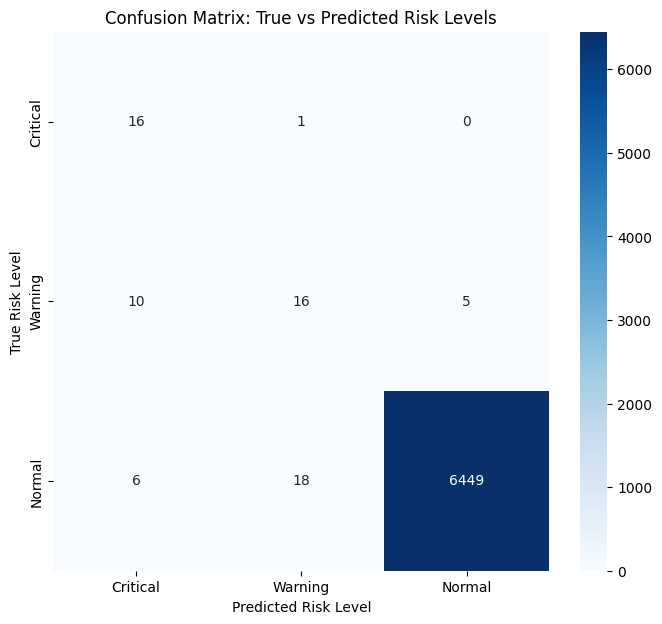

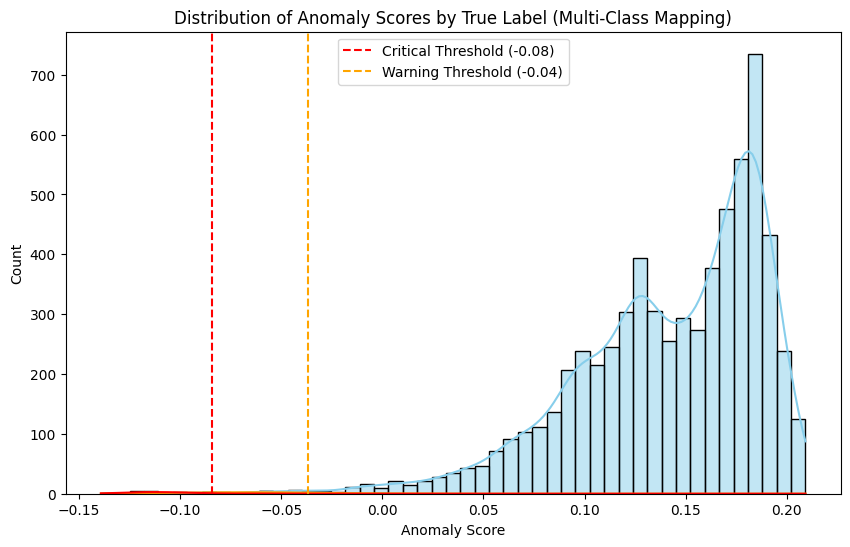

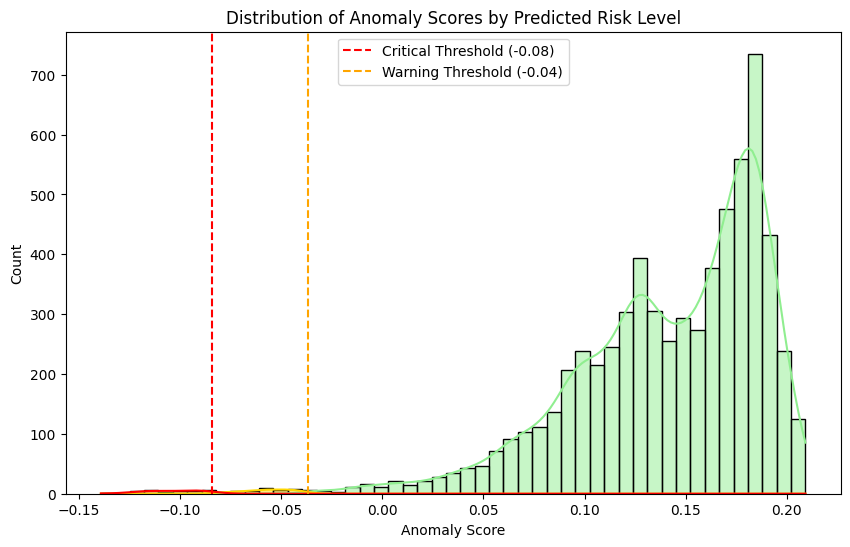

In [7]:

# --- 6. Visualizations ---
# Visualize Confusion Matrix for multi-class
plt.figure(figsize=(8, 7))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_order,
            yticklabels=label_order)
plt.title('Confusion Matrix: True vs Predicted Risk Levels')
plt.xlabel('Predicted Risk Level')
plt.ylabel('True Risk Level')
plt.show()

# Visualize Anomaly Score Distribution by True Label (re-using previous plot logic)
plt.figure(figsize=(10, 6))
sns.histplot(df_val, x='anomaly_score', hue='true_label_mapped_multi', kde=True,
             palette={'Normal': 'skyblue', 'Critical': 'red', 'Warning': 'orange'}, # Adjust palette for new labels
             hue_order=label_order) # Ensure consistent order
plt.title('Distribution of Anomaly Scores by True Label (Multi-Class Mapping)')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.axvline(x=crit_thresh, color='red', linestyle='--', label=f'Critical Threshold ({crit_thresh:.2f})')
plt.axvline(x=warn_thresh, color='orange', linestyle='--', label=f'Warning Threshold ({warn_thresh:.2f})')
plt.legend()
plt.show()

# Visualize Anomaly Score Distribution by Predicted Risk (already good)
plt.figure(figsize=(10, 6))
sns.histplot(df_val, x='anomaly_score', hue='predicted_risk', kde=True,
             palette={'Normal': 'lightgreen', 'Warning': 'gold', 'Critical': 'red'},
             hue_order=label_order) # Use the same order for consistency
plt.title('Distribution of Anomaly Scores by Predicted Risk Level')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.axvline(x=crit_thresh, color='red', linestyle='--', label=f'Critical Threshold ({crit_thresh:.2f})')
plt.axvline(x=warn_thresh, color='orange', linestyle='--', label=f'Warning Threshold ({warn_thresh:.2f})')
plt.legend()
plt.show()